In [1]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import soundfile as sf
import torchaudio.transforms as T


# Wczytywanie plików audio

In [2]:
class AudioDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        If root_dir contains subfolders, each is treated as a label.
        Otherwise, root_dir is assumed to be a single class.
        Labels are remapped so that only allowed test classes are kept;
        all other labels are mapped to "unknown".
        """
        self.root_dir = root_dir
        self.transform = transform
        self.filepaths = []
        self.labels = []
        self.label2idx = {}
        self.idx2label = {}

        # Allowed test classes from train (silence is not expected in train)
        allowed = {"yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"}
        
        subdirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        
        if subdirs:
            # Find allowed labels that appear in the training folders.
            allowed_in_train = sorted([d for d in subdirs if d in allowed])
            # If any subfolder is not in allowed, we will assign it the label "unknown"
            has_unknown = any(d not in allowed for d in subdirs)
            
            # Create label-to-index mapping:
            current_idx = 0
            for label in allowed_in_train:
                self.label2idx[label] = current_idx
                self.idx2label[current_idx] = label
                current_idx += 1
            if has_unknown:
                self.label2idx["unknown"] = current_idx
                self.idx2label[current_idx] = "unknown"
            
            # Read files and map labels accordingly.
            for label in subdirs:
                label_path = os.path.join(root_dir, label)
                for f in os.listdir(label_path):
                    if f.endswith(".wav"):
                        filepath = os.path.join(label_path, f)
                        # If label is allowed, keep it; otherwise, use "unknown"
                        mapped_label = label if label in allowed else "unknown"
                        self.filepaths.append(filepath)
                        self.labels.append(self.label2idx[mapped_label])
        else:
            # No subdirectories – root_dir is treated as one class.
            label = os.path.basename(root_dir)
            mapped_label = label if label in allowed else "unknown"
            self.label2idx[mapped_label] = 0
            self.idx2label[0] = mapped_label
            for f in os.listdir(root_dir):
                if f.endswith(".wav"):
                    self.filepaths.append(os.path.join(root_dir, f))
                    self.labels.append(0)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        label = self.labels[idx]
    
        # Load audio using soundfile
        data, sample_rate = sf.read(filepath)
        waveform = torch.tensor(data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
     
        if self.transform:
            waveform = self.transform(waveform)
    
        return waveform, label

# Transformation: MelSpectrogram + AmplitudeToDB
mel_transform = T.MelSpectrogram(sample_rate=16000, n_mels=64)
db_transform = T.AmplitudeToDB()

def to_mel_spectrogram(waveform):
    waveform = waveform.float() 
    spec = mel_transform(waveform)
    spec_db = db_transform(spec)
    return spec_db  # shape: [1, n_mels, time]

# Function collate, which pads spectrograms of different time lengths
def pad_collate_fn(batch):
    """
    batch: list of tuples (spectrogram, label)
    We assume each spectrogram has shape [1, n_mels, time]
    """
    spectrograms, labels = zip(*batch)
    
    max_time = max(s.size(2) for s in spectrograms)
    
    padded_spectrograms = []
    for s in spectrograms:
        pad_amount = max_time - s.size(2)
        s_padded = F.pad(s, (0, pad_amount), mode='constant', value=0)
        padded_spectrograms.append(s_padded)
    
    batch_spectrograms = torch.stack(padded_spectrograms)
    batch_labels = torch.tensor(labels)
    return batch_spectrograms, batch_labels

# EDA

In [ ]:
# Test usage of AudioDataset
dataset = AudioDataset(root_dir=os.path.join("..", "data", "train", "audio"), transform=None)

print("Liczba przykładów w dataset:", len(dataset))

waveform, label = dataset[2000]
print("Kształt waveforma:", waveform.shape)  # [1, no. of samples]
print("Etykieta (indeks):", label)
print("Etykieta (nazwisko):", dataset.idx2label[label])

plt.figure(figsize=(10, 3))
plt.title(f"Waveform - klasa: {dataset.idx2label[label]}")
plt.plot(waveform.t().numpy())
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'data/train/audio'

# Spektogram

In [6]:
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000, 
    n_mels=64
)
db_transform = torchaudio.transforms.AmplitudeToDB()

def to_mel_spectrogram(waveform):
    spec = mel_transform(waveform)
    spec_db = db_transform(spec)
    return spec_db


Kształt spektrogramu (Mel, dB): torch.Size([1, 64, 81])


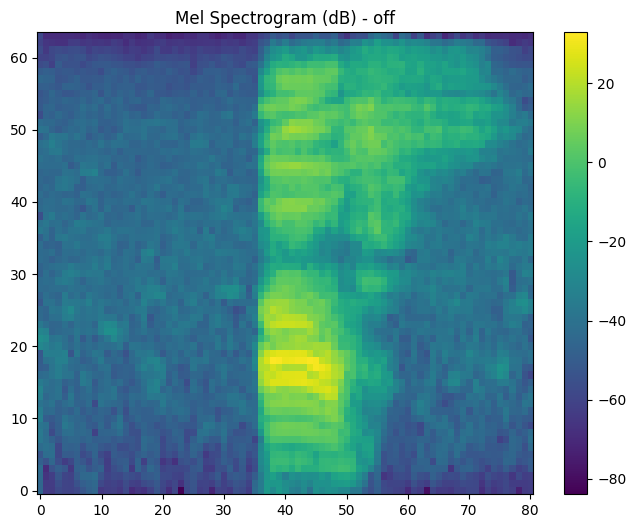

In [7]:
waveform, label = dataset[0]
waveform = waveform.float()  # conversion to float32
spec_db = to_mel_spectrogram(waveform)

print("Kształt spektrogramu (Mel, dB):", spec_db.shape)  # [1, n_mels, time]

plt.figure(figsize=(8, 6))
plt.title(f"Mel Spectrogram (dB) - {dataset.idx2label[label]}")
plt.imshow(spec_db.squeeze().numpy(), origin="lower", aspect="auto", cmap="viridis")
plt.colorbar()
plt.show()


# Zaladowanie danych treningowych

In [8]:
dataset_spec = AudioDataset(root_dir=os.path.join("data", "train", "audio"), transform=to_mel_spectrogram)

# Checking of shape
x, y = dataset_spec[0]
print("Kształt X (spektrogramu):", x.shape)  # [1, n_mels, time]
print("Etykieta:", y, dataset_spec.idx2label[y])


Kształt X (spektrogramu): torch.Size([1, 64, 81])
Etykieta: 4 off


## Podział na zbiór treningowy i walidacyjny

In [9]:
train_size = int(0.8 * len(dataset_spec))
val_size = len(dataset_spec) - train_size

train_dataset, val_dataset = random_split(dataset_spec, [train_size, val_size])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_fn)

print("Liczba próbek w train_loader:", len(train_dataset))
print("Liczba próbek w val_loader:", len(val_dataset))


Liczba próbek w train_loader: 53701
Liczba próbek w val_loader: 13426


## Accuracy dla przypisania najliczniej reprezentowanej klasy

In [10]:
all_labels = [dataset_spec[i][1] for i in range(len(dataset_spec))]
most_common_label = max(set(all_labels), key=all_labels.count)
baseline_acc = all_labels.count(most_common_label) / len(all_labels) * 100

print(f"Najczęstsza klasa: {dataset_spec.idx2label[most_common_label]}")
print(f"Baseline accuracy (majority class): {baseline_acc:.2f}%")


Najczęstsza klasa: unknown
Baseline accuracy (majority class): 64.72%


# CNN

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Input: [batch, 1, n_mels, time]

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.AdaptiveMaxPool2d((8, 8))  # -> [batch, 16, 8, 8]

        self.fc1 = nn.Linear(16 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: [batch, 1, n_mels, time]
        x = F.relu(self.conv1(x))    # -> [batch, 8, n_mels, time]
        x = F.relu(self.conv2(x))    # -> [batch, 16, n_mels, time]
        x = self.pool(x)            # -> [batch, 16, 8, 8]
        x = x.view(x.size(0), -1)   # flattening to [batch, 16*8*8]
        x = F.relu(self.fc1(x))     # -> [batch, 64]
        x = self.fc2(x)             # -> [batch, num_classes]
        return x


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Urządzenie:", device)

Urządzenie: cpu


## Trening CNN

In [14]:
num_classes = len(dataset_spec.label2idx)
model = SimpleCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # inputs: [batch_size, 1, n_mels, time]
        # labels: [batch_size]
        inputs = inputs.to(device)
        labels = labels.to(device)

        
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward + opt
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average loss per epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")


[Epoch 1/2] Loss: 0.8470
[Epoch 2/2] Loss: 0.5036


# Walidacja

In [15]:
# Validation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs_val, labels_val in val_loader:
        inputs_val = inputs_val.to(device)
        labels_val = labels_val.to(device)

        outputs_val = model(inputs_val)
        _, predicted = torch.max(outputs_val, 1)
        total += labels_val.size(0)
        correct += (predicted == labels_val).sum().item()

val_acc = 100.0 * correct / total
print(f"Val Accuracy: {val_acc:.2f}%\n")

Val Accuracy: 83.41%



# Testy

1. Activation fuction (ReLU vs Sigmoid)

In [ ]:
def test_activation_function():
    relu_model = SimpleCNN(num_classes=10)
    sigmoid_model = SimpleCNN(num_classes=10)

    relu_model.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, 1, 1), nn.ReLU())
    sigmoid_model.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, 1, 1), nn.Sigmoid())

    dummy_input = torch.randn(2, 1, 64, 100)  # [batch, channels, n_mels, time]
    relu_out = relu_model(dummy_input)
    sigmoid_out = sigmoid_model(dummy_input)

    assert relu_out.shape == sigmoid_out.shape == (2, 10)

2. Pooling

In [ ]:
def test_pooling_variants():
    input_tensor = torch.randn(4, 8, 32, 32)

    max_pool = nn.AdaptiveMaxPool2d((8, 8))(input_tensor)
    avg_pool = nn.AdaptiveAvgPool2d((8, 8))(input_tensor)
    global_pool = nn.AdaptiveMaxPool2d((1, 1))(input_tensor)

    assert max_pool.shape == avg_pool.shape == (4, 8, 8, 8)
    assert global_pool.shape == (4, 8, 1, 1)